## 3rd Answer

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [ ]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 3
DEVICE = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 10

Device: cuda:0


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [ ]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    num_workers=2,
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
set_all_seeds(RANDOM_SEED)

model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [ ]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model,
                                optimizer=optimizer, device=DEVICE,
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/010 | Batch 0000/1875 | Loss: 0.2998
Epoch: 001/010 | Batch 0250/1875 | Loss: 0.0512
Epoch: 001/010 | Batch 0500/1875 | Loss: 0.0559
Epoch: 001/010 | Batch 0750/1875 | Loss: 0.0524
Epoch: 001/010 | Batch 1000/1875 | Loss: 0.0459
Epoch: 001/010 | Batch 1250/1875 | Loss: 0.0526
Epoch: 001/010 | Batch 1500/1875 | Loss: 0.0468
Epoch: 001/010 | Batch 1750/1875 | Loss: 0.0522
Time elapsed: 0.86 min
Epoch: 002/010 | Batch 0000/1875 | Loss: 0.0470
Epoch: 002/010 | Batch 0250/1875 | Loss: 0.0497
Epoch: 002/010 | Batch 0500/1875 | Loss: 0.0488
Epoch: 002/010 | Batch 0750/1875 | Loss: 0.0458
Epoch: 002/010 | Batch 1000/1875 | Loss: 0.0448
Epoch: 002/010 | Batch 1250/1875 | Loss: 0.0451
Epoch: 002/010 | Batch 1500/1875 | Loss: 0.0422
Epoch: 002/010 | Batch 1750/1875 | Loss: 0.0425
Time elapsed: 1.62 min
Epoch: 003/010 | Batch 0000/1875 | Loss: 0.0453
Epoch: 003/010 | Batch 0250/1875 | Loss: 0.0446
Epoch: 003/010 | Batch 0500/1875 | Loss: 0.0447
Epoch: 003/010 | Batch 0750/1875 | Loss: 0

## Evaluation

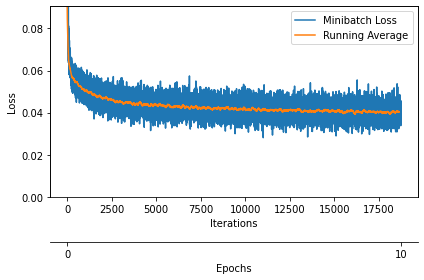

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

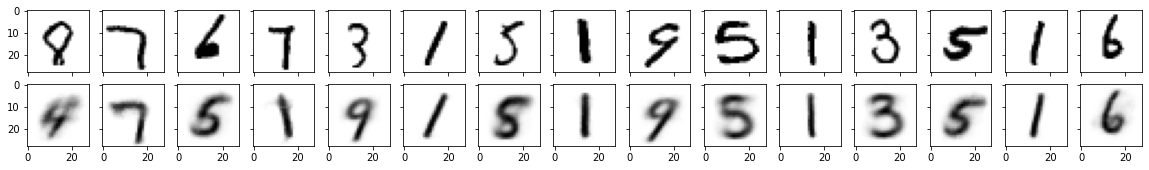

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)

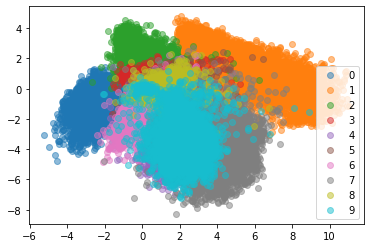

In [ ]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    model=model,
    device=DEVICE)

plt.legend()
plt.show()

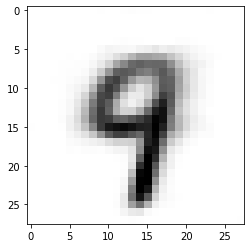

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.5, -2.5]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

In [ ]:
import numpy as np

In [ ]:
def plot_reconstructed(model, r0=(-1, 1), r1=(-1, 1), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

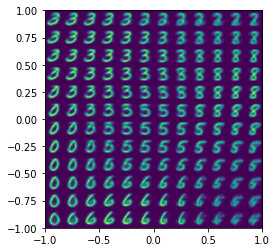

In [ ]:
plot_reconstructed(model)

## We can see that the last 3 values from the latent space where r0 is between 0.5 and 1.0 and r1 is -1, the values are not like any handwritten digits.

## All the other values take the shapes of 0, 3, 5, 6 and 8.